In [10]:
from tespy.components import Compressor, HeatExchangerSimple, Valve, CycleCloser
from tespy.networks import Network
from tespy.connections import Connection

In [11]:
wf = "R290"
nwk = Network(fluids=[wf], p_unit="bar", T_unit="C", iterinfo=False)

In [12]:
cp = Compressor("compressor")
cd = HeatExchangerSimple("condenser")
va = Valve("valve")
ev = HeatExchangerSimple("evaporator")

cc = CycleCloser("cycle closer")

c1 = Connection(cc, "out1", ev, "in1")
c2 = Connection(ev, "out1", cp, "in1")
c3 = Connection(cp, "out1", cd, "in1")
c4 = Connection(cd, "out1", va, "in1")
c0 = Connection(va, "out1", cc, "in1")

nwk.add_conns(c1, c2, c3, c4, c0)

In [13]:
c1.set_attr(fluid={"R290": 1})
c2.set_attr(T=2, x=1)
c4.set_attr(T=40, x=0)

cp.set_attr(eta_s=0.8)
cd.set_attr(pr=1, Q=-9.1e3)
ev.set_attr(pr=1)

In [14]:
nwk.solve("design")
nwk.print_results()

##### RESULTS (HeatExchangerSimple) #####
+------------+-----------+----------+----------+-----+-----+------+------+--------+
|            |         Q |       pr |     zeta |   D |   L |   ks |   kA |   Tamb |
|------------+-----------+----------+----------+-----+-----+------+------+--------|
| condenser  | -9.10e+03 | 1.00e+00 | 1.99e-05 | nan | nan |  nan |  nan |    nan |
| evaporator |  7.48e+03 | 1.00e+00 | 1.59e-06 | nan | nan |  nan |  nan |    nan |
+------------+-----------+----------+----------+-----+-----+------+------+--------+
##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|--------------+------------------+-------------------|
| cycle closer |         0.00e+00 |          0.00e+00 |
+--------------+------------------+-------------------+
##### RESULTS (Compressor) #####
+------------+----------+----------+----------+--------+
|            |        P |    eta_s |       pr |   

In [15]:
abs(cd.Q.val) / cp.P.val

5.622635963759939

In [16]:
cp.set_attr(eta_s=0.675)
nwk.solve("design")
abs(cd.Q.val) / cp.P.val

4.900349094423101

In [17]:
import pandas as pd
import numpy as np


temperature_range = np.arange(-15, 16)
results = pd.DataFrame(index=temperature_range + 5, columns=["COP", "COP_carnot"])

cp.eta_s.val

for T in temperature_range:
    c2.set_attr(T=T)
    nwk.solve("design")
    results.loc[T + 5, "COP"] = abs(cd.Q.val) / cp.P.val
    results.loc[T + 5, "COP_carnot"] = c4.T.val_SI / (c4.T.val - c2.T.val)

results["efficiency"] = results["COP"] / results["COP_carnot"]

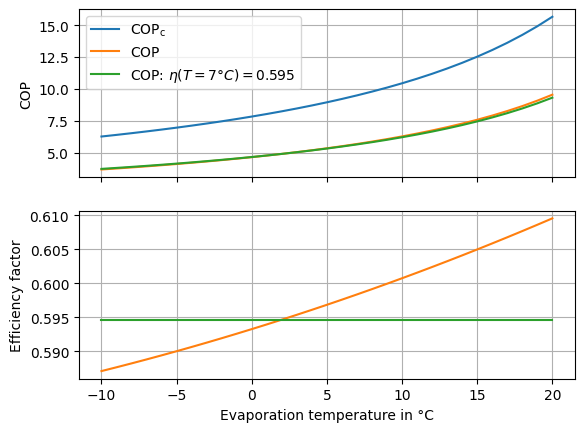

In [18]:
from matplotlib import pyplot as plt


T_for_eta = 7
eta_const = results.loc[T_for_eta, "efficiency"]

fig, ax = plt.subplots(2, sharex=True)

label = "$\mathrm{COP}_\mathrm{c}$"
ax[0].plot(temperature_range, results["COP_carnot"], label=label)
ax[0].plot(temperature_range, results["COP"], label="$\mathrm{COP}$")
label = "$\mathrm{COP}$: $\eta\left(T=" + str(T_for_eta) + "°C\\right)=" + str(round(eta_const, 3)) + "$"
ax[0].plot(temperature_range, results["COP_carnot"] * eta_const, label=label)
ax[0].set_ylabel("COP")
ax[0].legend()

ax[1].plot(temperature_range, results["efficiency"], color="tab:orange")
ax[1].plot(temperature_range, [eta_const for _ in temperature_range], color="tab:green")
ax[1].set_ylabel("Efficiency factor")

ax[1].set_xlabel("Evaporation temperature in °C")

[(a.grid(), a.set_axisbelow(True)) for a in ax];

In [19]:
export = results[["COP"]]
export.index.names = ["temperature"]
export.to_csv("COP-T-tespy.csv")